In [45]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as font_manager

from pathlib import Path
from scipy.stats import linregress

from standes.visualise.model import plot_model_2d

In [46]:
# Folders
ROOT = Path("E:/")
CASE_STUDIES = ROOT / "case_study_structures"
ANALYSIS_OUT = ROOT / "analysis_out"
GM_FOLDER = ROOT / "gm_records_p695"

ductility_classes = [2]


In [47]:
# load the modal analysis data into dictionaries
modal_file = "modal_properties.json"
modal_data = {}

building_names = list(os.walk(ANALYSIS_OUT))[0][1]
for building_name in building_names:
    modal_data_folder = ANALYSIS_OUT / building_name / "modal"

    with open(modal_data_folder / modal_file, "r") as file:
        modal_data[building_name] = json.load(file) 

building_data_dicts = {}
for name, data in modal_data.items():
    building_data = {
        "name": name,
        "n_storeys": int(name[0]),
        "design_level": float(name.split("_")[-1]) / 100,
        "ductility_class": int(name.split("_")[2][-1]),
        "T1": data["eigenPeriod"][0],
        "T2": data["eigenPeriod"][1],
        "T3": data["eigenPeriod"][2],
        "mass_ratio_1": data["partiMassRatiosMX"][0],
        "mass_ratio_2": data["partiMassRatiosMX"][1],
        "mass_ratio_3": data["partiMassRatiosMX"][2]
    }
    building_data_dicts[name] = building_data

In [48]:
# mapping parameters from design output to columns for df
design_out_parameter_map = {
    "V_wind_GQWSI_LC1": "['nonseismic_design_outputs']['GQWSI_LC1']['uls_wind_base_shear']",
    "V_wind_GQWSI_LC2": "['nonseismic_design_outputs']['GQWSI_LC2']['uls_wind_base_shear']",
    "V_wind_GQWSI_LC3": "['nonseismic_design_outputs']['GQWSI_LC3']['uls_wind_base_shear']",
    "T1_GQWSI_LC1": "['nonseismic_design_outputs']['GQWSI_LC1']['period']",
    "T1_GQWSI_LC2": "['nonseismic_design_outputs']['GQWSI_LC2']['period']",
    "T1_GQWSI_LC3": "['nonseismic_design_outputs']['GQWSI_LC3']['period']",
    "gravity_frame_elastic_baseshear": "['seismic_design_outputs']['gravity_frame_elastic_baseshear']",
    "gravity_design_equivalent_seismic_baseshear": "['seismic_design_outputs']['gravity_design_equivalent_seismic_baseshear']",
    "seismic_mass":"['seismic_design_outputs']['seismic_mass']",
    "ductility_class":"['seismic_design_outputs']['ductility_class']",    
    "vertical_regularity":"['seismic_design_outputs']['vertical_regularity']",
    "q_design":"['seismic_design_outputs']['q_design']",
    "q_D":"['seismic_design_outputs']['q_D']",
    "q_R":"['seismic_design_outputs']['q_R']",
    "q_S":"['seismic_design_outputs']['q_S']",
    "q_max":"['seismic_design_outputs']['q_max']",
    "design_period":"['seismic_design_outputs']['design_period']",
    "design_spectral_acceleration":"['seismic_design_outputs']['design_spectral_acceleration']",
    "design_baseshear":"['seismic_design_outputs']['design_baseshear']",
    "lambda_":"['seismic_design_outputs']['lambda']",
    "S_alpha_RP":"['seismic_design_outputs']['spectrum_parameters']['S_alpha_RP']",
    "S_beta_RP":"['seismic_design_outputs']['spectrum_parameters']['S_beta_RP']",
    "S_alpha":"['seismic_design_outputs']['spectrum_parameters']['S_alpha']",
    "S_beta":"['seismic_design_outputs']['spectrum_parameters']['S_beta']",
    "T_beta":"['seismic_design_outputs']['spectrum_parameters']['T_beta']",
    "T_A":"['seismic_design_outputs']['spectrum_parameters']['T_A']",
    "T_B":"['seismic_design_outputs']['spectrum_parameters']['T_B']",
    "T_C":"['seismic_design_outputs']['spectrum_parameters']['T_C']",
    "T_D":"['seismic_design_outputs']['spectrum_parameters']['T_D']",
    "F_alpha":"['seismic_design_outputs']['spectrum_parameters']['F_alpha']",
    "F_beta":"['seismic_design_outputs']['spectrum_parameters']['F_beta']",
    "F_T":"['seismic_design_outputs']['spectrum_parameters']['F_T']",
    "F_A":"['seismic_design_outputs']['spectrum_parameters']['F_A']",
    "site_category":"['seismic_design_outputs']['spectrum_parameters']['site_category']",
    "S_delta":"['seismic_design_outputs']['spectrum_parameters']['S_delta']",
    "delta":"['seismic_design_outputs']['spectrum_parameters']['delta']",
    "site_category":"['seismic_design_outputs']['spectrum_parameters']['seismic_action_class']"
}

In [49]:
#Funktion zur auslesung eines wertes definieren
def read_out_value(data,path):
    try:
        return eval("data" + path)
    except:
        return np.nan

In [50]:
# load the design output data into the dictionaries 
design_data = {}
for dc in ductility_classes:  
    design_out_folder = CASE_STUDIES / f"DC{dc}" / "design_output_json_files"
    building_files = [f for f in os.listdir(design_out_folder) if not "log" in f]

    for building_file in building_files:
        building_name = building_file[:-9]
        with open(design_out_folder / building_file, "r") as file:
            design_data[building_name] = json.load(file) 

for name, data in design_data.items():
    try:
        building_data = building_data_dicts[name]
        for df_tag, dd_path in design_out_parameter_map.items():
            building_data[df_tag] = read_out_value(data, dd_path)
        
        if building_data["ductility_class"] == 0:
            building_data["design_baseshear"] = 0
            building_data["site_category"] = "very low"
        building_data["n_storeys"] = len(data["structure"]["level_coordinates"]) - 1
        building_data["n_bays"] = len(data["structure"]["grid_coordinates"]) - 1
        building_data["height"] = data["structure"]["level_coordinates"][-1]
        building_data["width"] = building_width = data["structure"]["grid_coordinates"][-1]
    except KeyError:
        ...    

In [51]:
# load the fragility curve data into the dictionaries
collapse_fragility_file = "collapse_fragility.json"
fragility_data = {}
g = 9810

building_names = list(os.walk(ANALYSIS_OUT))[0][1]
for building_name in building_names:
    ida_data_folder = ANALYSIS_OUT / building_name / "ida_SA"

    with open(ida_data_folder / "post_processing" / collapse_fragility_file, "r") as file:
        fragility_data[building_name] = json.load(file) 

for name, data in fragility_data.items():
    building_data = building_data_dicts[name]
    building_data["theta_c_SaT1"] = data["median"] / g
    building_data["beta_c_SaT1"] = data["dispersion"]


In [52]:
building_data_df = pd.DataFrame(building_data_dicts.values())

In [53]:
building_data_df["vb_coeff"] = building_data_df["design_baseshear"] / (building_data_df["seismic_mass"] * 9.81)
building_data_df["cmr"] = building_data_df["theta_c_SaT1"] / (building_data_df["design_spectral_acceleration"])

In [54]:
building_data_df

,name,n_storeys,design_level,ductility_class,T1,T2,T3,mass_ratio_1,mass_ratio_2,mass_ratio_3,...,F_T,F_A,site_category,S_delta,delta,n_bays,height,width,vb_coeff,cmr
0,3s_cbf_dc0_0,3,0.00,0,0.707126,0.252315,0.166061,88.796787,9.439701,1.750595e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3s_cbf_dc2_10,3,0.10,2,0.649888,0.240027,0.151604,88.823450,9.330153,1.833209e+00,...,1.0,2.5,low,0.156800,1.0,3.0,10500.0,21000.0,0.026098,44.779679
2,3s_cbf_dc2_102,3,1.02,2,0.297810,0.105135,0.074669,84.109662,12.084013,6.719829e-07,...,1.0,2.5,high,1.299072,1.0,3.0,10500.0,21000.0,0.492073,6.059832
3,3s_cbf_dc2_122,3,1.22,2,0.281767,0.101452,0.074388,83.445336,12.458884,7.239426e-07,...,1.0,2.5,high,1.475712,1.0,3.0,10500.0,21000.0,0.558982,6.216935
4,3s_cbf_dc2_20,3,0.20,2,0.541700,0.194938,0.123839,88.825179,9.411824,1.739859e+00,...,1.0,2.5,low,0.307200,1.0,3.0,10500.0,21000.0,0.065958,18.117311
5,3s_cbf_dc2_31,3,0.31,2,0.447962,0.165406,0.102322,84.872104,11.778375,3.291886e+00,...,1.0,2.5,moderate,0.465248,1.0,3.0,10500.0,21000.0,0.152712,8.953518
6,3s_cbf_dc2_41,3,0.41,2,0.408288,0.146735,0.092269,84.487736,11.849241,3.582587e+00,...,1.0,2.5,moderate,0.602208,1.0,3.0,10500.0,21000.0,0.217078,7.710910
7,3s_cbf_dc2_51,3,0.51,2,0.366747,0.134082,0.087660,83.655715,12.275207,1.267465e-06,...,1.0,2.5,high,0.732768,1.0,3.0,10500.0,21000.0,0.277564,7.160399
8,3s_cbf_dc2_61,3,0.61,2,0.350979,0.125884,0.081603,83.474234,12.322531,5.345955e-07,...,1.0,2.5,high,0.856928,1.0,3.0,10500.0,21000.0,0.324594,7.116617
9,3s_cbf_dc2_71,3,0.71,2,0.333037,0.121442,0.081240,83.105765,12.560690,9.672799e-07,...,1.0,2.5,high,0.974688,1.0,3.0,10500.0,21000.0,0.369200,7.101730


In [55]:
building_data_df.columns

Index(['name', 'n_storeys', 'design_level', 'ductility_class', 'T1', 'T2',
       'T3', 'mass_ratio_1', 'mass_ratio_2', 'mass_ratio_3', 'theta_c_SaT1',
       'beta_c_SaT1', 'V_wind_GQWSI_LC1', 'V_wind_GQWSI_LC2',
       'V_wind_GQWSI_LC3', 'T1_GQWSI_LC1', 'T1_GQWSI_LC2', 'T1_GQWSI_LC3',
       'gravity_frame_elastic_baseshear',
       'gravity_design_equivalent_seismic_baseshear', 'seismic_mass',
       'vertical_regularity', 'q_design', 'q_D', 'q_R', 'q_S', 'q_max',
       'design_period', 'design_spectral_acceleration', 'design_baseshear',
       'lambda_', 'S_alpha_RP', 'S_beta_RP', 'S_alpha', 'S_beta', 'T_beta',
       'T_A', 'T_B', 'T_C', 'T_D', 'F_alpha', 'F_beta', 'F_T', 'F_A',
       'site_category', 'S_delta', 'delta', 'n_bays', 'height', 'width',
       'vb_coeff', 'cmr'],
      dtype='object')

In [56]:
# remove the design levels > 71
building_data_df = building_data_df[building_data_df["design_level"] <= 0.71]

# filling NaN with zeros where needed
building_data_df["design_spectral_acceleration"] = building_data_df["design_spectral_acceleration"].fillna(0)

C:\Users\clemettn\AppData\Local\Temp\ipykernel_17300\919726990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_data_df["design_spectral_acceleration"] = building_data_df["design_spectral_acceleration"].fillna(0)


In [57]:
df_3s = building_data_df[(building_data_df["n_storeys"] == 3) & (building_data_df["design_level"] != 0)]
df_5s = building_data_df[(building_data_df["n_storeys"] == 5) & (building_data_df["design_level"] != 0)]
df_7s = building_data_df[(building_data_df["n_storeys"] == 7) & (building_data_df["design_level"] != 0)]


In [58]:
df_3s["design_spectral_acceleration"]

1    0.026098
4    0.065958
5    0.179661
6    0.255386
7    0.326545
8    0.381875
9    0.434353
Name: design_spectral_acceleration, dtype: float64

In [59]:
df_3s["name"]

1    3s_cbf_dc2_10
4    3s_cbf_dc2_20
5    3s_cbf_dc2_31
6    3s_cbf_dc2_41
7    3s_cbf_dc2_51
8    3s_cbf_dc2_61
9    3s_cbf_dc2_71
Name: name, dtype: object

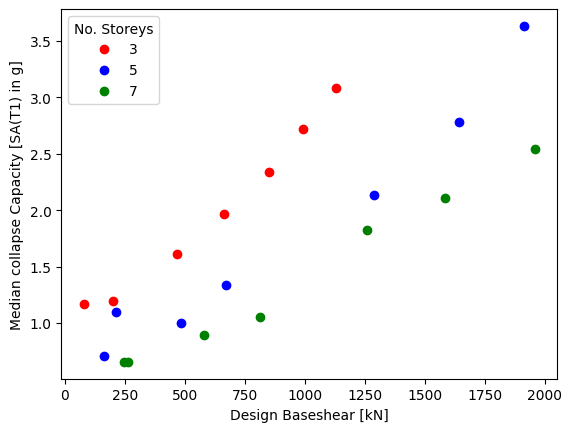

In [60]:
# plot some stuff
plt.figure()
ax = plt.gca()
ax.plot(df_3s["design_baseshear"] / 1e3, df_3s["theta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["design_baseshear"] / 1e3, df_5s["theta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["design_baseshear"] / 1e3, df_7s["theta_c_SaT1"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Baseshear [kN]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.legend(title="No. Storeys")

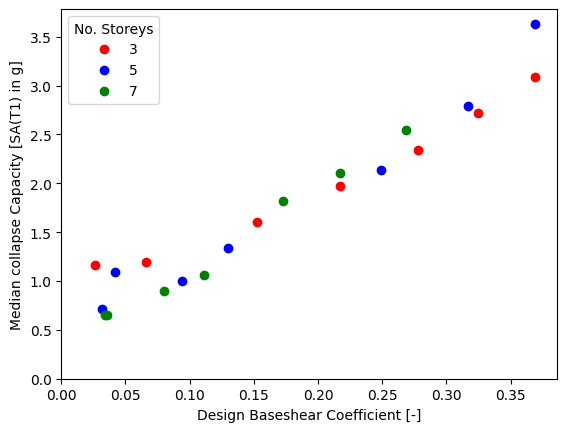

In [61]:
# same plot but with base shear normalised by the seismic weight of the structure
# plot some stuff
plt.figure()
ax = plt.gca()
ax.plot(df_3s["vb_coeff"], df_3s["theta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["vb_coeff"], df_5s["theta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["vb_coeff"], df_7s["theta_c_SaT1"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title="No. Storeys")

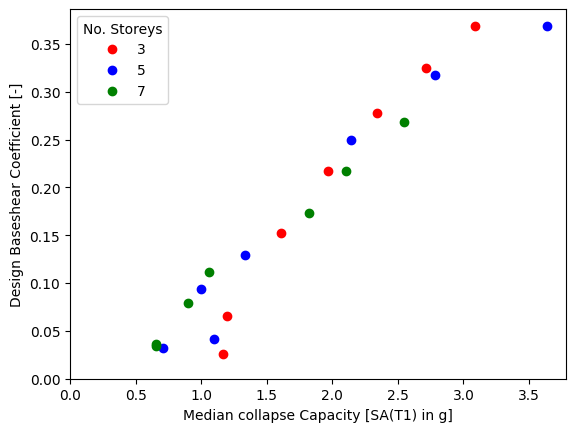

In [62]:
# plotting the base shear coefficient as a function of the median collapse capacity
plt.figure()
ax = plt.gca()
ax.plot(df_3s["theta_c_SaT1"], df_3s["vb_coeff"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["theta_c_SaT1"], df_5s["vb_coeff"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["theta_c_SaT1"], df_7s["vb_coeff"], color= "g", marker="o", ls="", label="7")
ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title="No. Storeys")

0.3 1.2


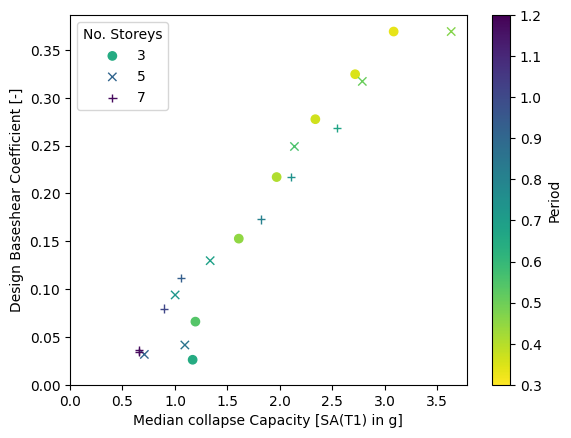

In [63]:
periods = np.concatenate([df_3s["T1"], df_5s["T1"], df_7s["T1"]])
vmin, vmax = 0.3, 1.2
print(vmin, vmax)

fig, ax = plt.subplots()

sc1 = ax.scatter(df_3s["theta_c_SaT1"], df_3s["vb_coeff"], c=df_3s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="o", ls="", label="3")
sc2 = ax.scatter(df_5s["theta_c_SaT1"], df_5s["vb_coeff"], c=df_5s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="x", ls="", label="5")
sc3 = ax.scatter(df_7s["theta_c_SaT1"], df_7s["vb_coeff"], c=df_7s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="+", ls="", label="7")

ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title="No. Storeys")

cbar = fig.colorbar(sc1, ax=ax)
cbar.set_label("Period")

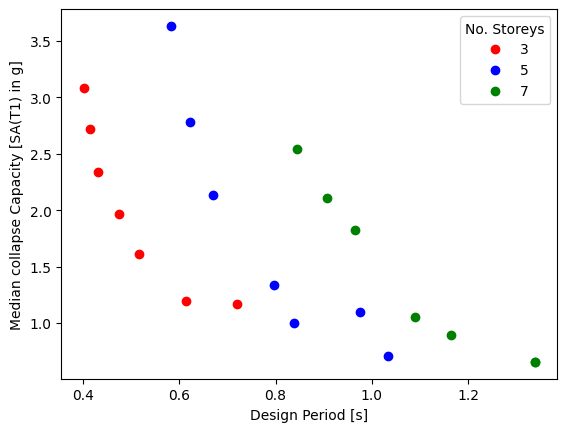

In [64]:
plt.figure()
ax = plt.gca()
ax.plot(df_3s["design_period"], df_3s["theta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["design_period"], df_5s["theta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["design_period"], df_7s["theta_c_SaT1"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Period [s]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.legend(title="No. Storeys")

0.3 1.2


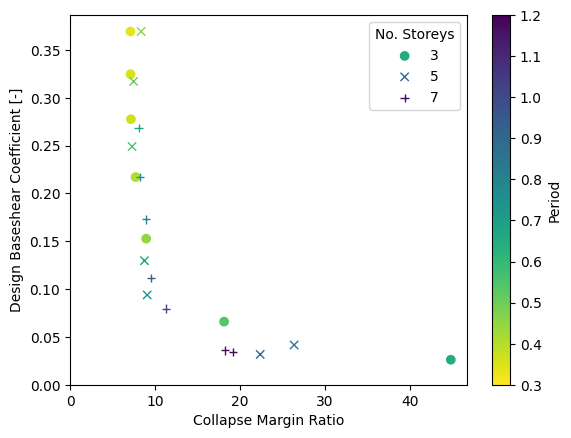

In [65]:
periods = np.concatenate([df_3s["T1"], df_5s["T1"], df_7s["T1"]])
vmin, vmax = 0.3, 1.2
print(vmin, vmax)

fig, ax = plt.subplots()

sc1 = ax.scatter(df_3s["cmr"], df_3s["vb_coeff"], c=df_3s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="o", ls="", label="3")
sc2 = ax.scatter(df_5s["cmr"], df_5s["vb_coeff"], c=df_5s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="x", ls="", label="5")
sc3 = ax.scatter(df_7s["cmr"], df_7s["vb_coeff"], c=df_7s["T1"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="+", ls="", label="7")

ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Collapse Margin Ratio")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title="No. Storeys")

cbar = fig.colorbar(sc1, ax=ax)
cbar.set_label("Period")

0.1 0.71


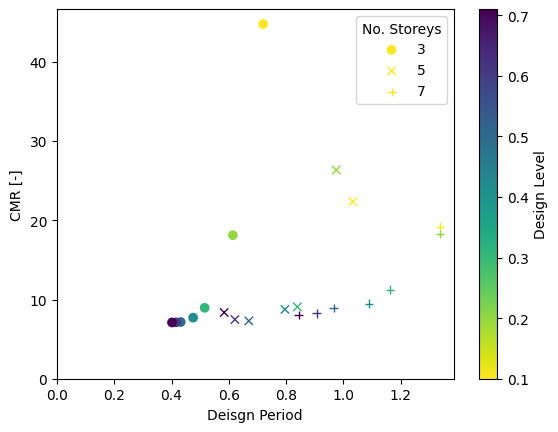

In [68]:
design_level = np.concatenate([df_3s["design_level"], df_5s["design_level"], df_7s["design_level"]])
vmin, vmax = 0.1, 0.71
print(vmin, vmax)

fig, ax = plt.subplots()

sc1 = ax.scatter(df_3s["design_period"], df_3s["cmr"], c=df_3s["design_level"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="o", ls="", label="3")
sc2 = ax.scatter(df_5s["design_period"], df_5s["cmr"], c=df_5s["design_level"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="x", ls="", label="5")
sc3 = ax.scatter(df_7s["design_period"], df_7s["cmr"], c=df_7s["design_level"], cmap="viridis_r", vmin=vmin, vmax=vmax, marker="+", ls="", label="7")

ax.set_ylabel("CMR [-]")
ax.set_xlabel("Deisgn Period")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title="No. Storeys")

cbar = fig.colorbar(sc1, ax=ax)
cbar.set_label("Design Level")

(0.0, 0.5639528186486353)

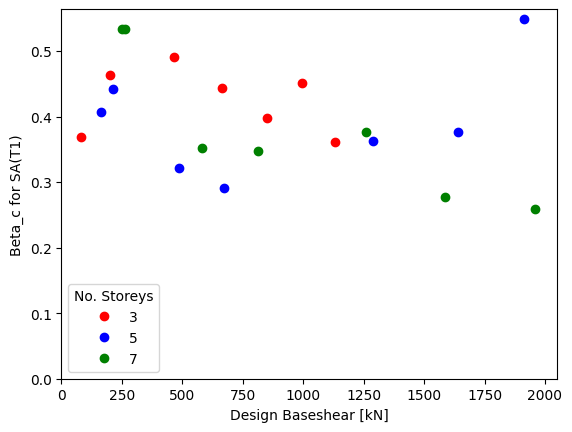

In [26]:
plt.figure()
ax = plt.gca()
ax.plot(df_3s["design_baseshear"] / 1e3, df_3s["beta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["design_baseshear"] / 1e3, df_5s["beta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["design_baseshear"] / 1e3, df_7s["beta_c_SaT1"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Baseshear [kN]")
ax.set_ylabel("Beta_c for SA(T1)")
ax.legend(title="No. Storeys")
ax.set_xlim(0)
ax.set_ylim(0)

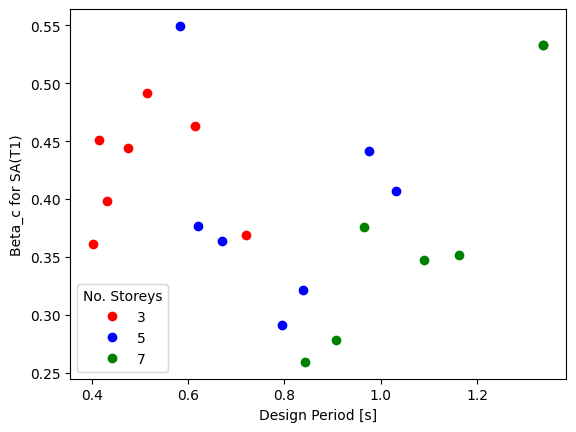

In [27]:
plt.figure()
ax = plt.gca()
ax.plot(df_3s["design_period"], df_3s["beta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["design_period"], df_5s["beta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["design_period"], df_7s["beta_c_SaT1"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Period [s]")
ax.set_ylabel("Beta_c for SA(T1)")
ax.legend(title="No. Storeys")

0.42538887258887215
0.39292672820132707
0.38269471735899746

0.4438991474334494
0.3764778102249648
0.35161243423431543


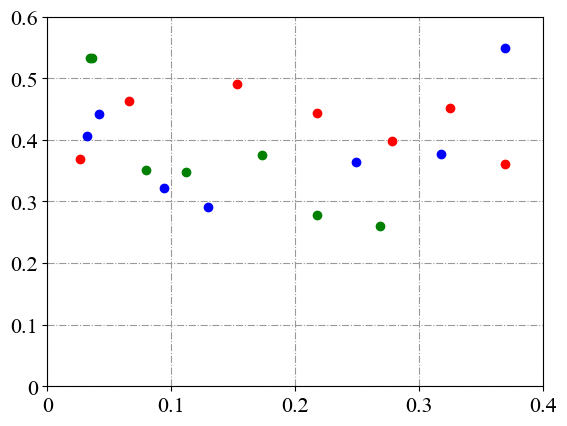

In [ ]:
# dispersion against base shear coefficient
plt.figure()
ax = plt.gca()
ax.plot(df_3s["vb_coeff"], df_3s["beta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["vb_coeff"], df_5s["beta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["vb_coeff"], df_7s["beta_c_SaT1"], color= "g", marker="o", ls="", label="7")

ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], font="Times New Roman", size=16)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4], [0, 0.1, 0.2, 0.3, 0.4], font="Times New Roman", size=16)
ax.grid(True, which="major", color="0.6", linestyle="-.")

ax.set_xlim(0)
ax.set_ylim(0, 0.6)

print(df_3s["beta_c_SaT1"].mean())
print(df_5s["beta_c_SaT1"].mean())
print(df_7s["beta_c_SaT1"].mean())

0.42538887258887215
0.39292672820132707
0.38269471735899746


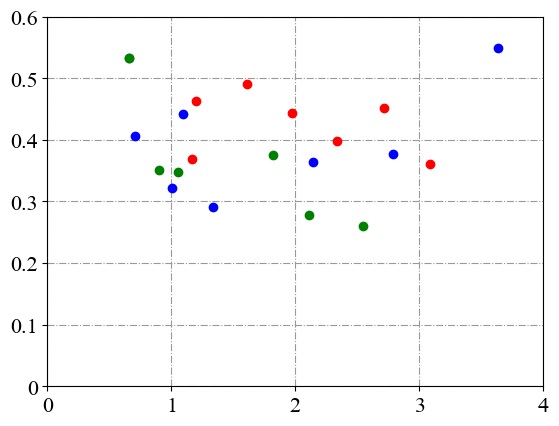

In [65]:
# dispersion against median collapse cacpacity
plt.figure()
ax = plt.gca()
ax.plot(df_3s["theta_c_SaT1"], df_3s["beta_c_SaT1"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["theta_c_SaT1"], df_5s["beta_c_SaT1"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["theta_c_SaT1"], df_7s["beta_c_SaT1"], color= "g", marker="o", ls="", label="7")

ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], font="Times New Roman", size=16)
ax.set_xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], font="Times New Roman", size=16)
ax.grid(True, which="major", color="0.6", linestyle="-.")

ax.set_xlim(0)
ax.set_ylim(0, 0.6)

print(df_3s["beta_c_SaT1"].mean())
print(df_5s["beta_c_SaT1"].mean())
print(df_7s["beta_c_SaT1"].mean())

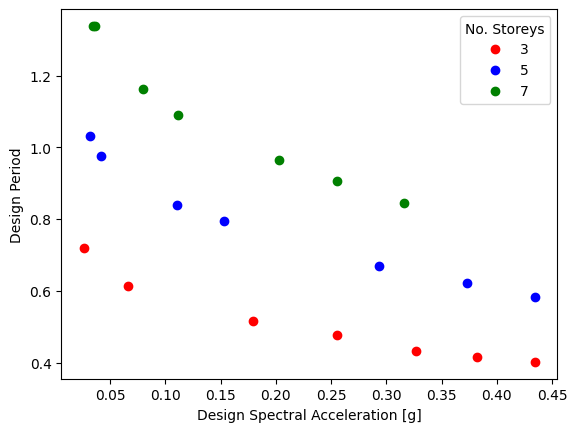

In [35]:
# design period against the design spectral acceleration
plt.figure()
ax = plt.gca()
ax.plot(df_3s["design_spectral_acceleration"], df_3s["design_period"], color= "r", marker="o", ls="", label="3")
ax.plot(df_5s["design_spectral_acceleration"], df_5s["design_period"], color= "b", marker="o", ls="", label="5")
ax.plot(df_7s["design_spectral_acceleration"], df_7s["design_period"], color= "g", marker="o", ls="", label="7")
ax.set_xlabel("Design Spectral Acceleration [g]")
ax.set_ylabel("Design Period")
ax.legend(title="No. Storeys")

## Regression relationships

Slope: 6.1959760616043615
Intercept: 0.6991590306984499
R value: 0.9937589439655099


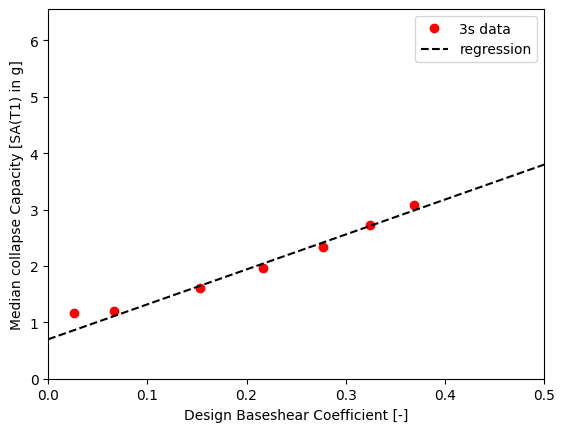

In [30]:
# perform a linear regression on the  level 3 data for base shear coefficient > 0.05
x_min = 0.05   # N
df = df_3s[df_3s["vb_coeff"] > x_min]

result_3s = linregress(df["vb_coeff"], df["theta_c_SaT1"])
print(f"Slope: {result_3s.slope}")
print(f"Intercept: {result_3s.intercept}")
print(f"R value: {result_3s.rvalue}")

x_3s = np.linspace(0, 0.9)
y_3s = result_3s.slope * x_3s + result_3s.intercept

plt.figure()
ax = plt.gca()
ax.plot(df_3s["vb_coeff"], df_3s["theta_c_SaT1"], color= "r", marker="o", ls="", label="3s data")
ax.plot(x_3s, y_3s, color= "k", marker="", ls="--", label="regression")
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0, 0.5)
ax.set_ylim(0)
ax.legend()

Slope: 8.932349866884916
Intercept: 0.10901652525935157
R value: 0.9867228234411313


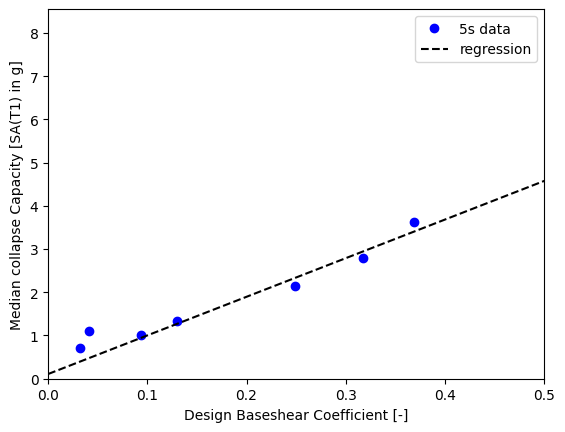

In [31]:
# perform a linear regression on the 5s data for base shear greater x Newtons
x_min = 0.05   # N
df = df_5s[df_5s["vb_coeff"] > x_min]

result_5s = linregress(df["vb_coeff"], df["theta_c_SaT1"])
print(f"Slope: {result_5s.slope}")
print(f"Intercept: {result_5s.intercept}")
print(f"R value: {result_5s.rvalue}")

x_5s = np.linspace(0, 0.9)
y_5s = result_5s.slope * x_5s + result_5s.intercept

plt.figure()
ax = plt.gca()
ax.plot(df_5s["vb_coeff"], df_5s["theta_c_SaT1"], color= "b", marker="o", ls="", label="5s data")
ax.plot(x_5s, y_5s, color= "k", marker="", ls="--", label="regression")
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0, 0.5)
ax.set_ylim(0)
ax.legend()

Slope: 9.060164273042375
Intercept: 0.14658438716488553
R value: 0.9938756920982779


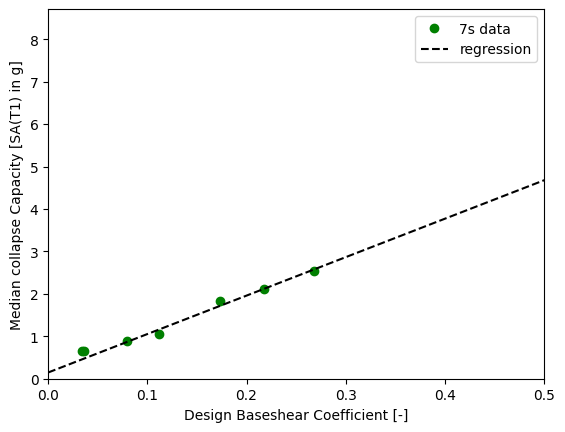

In [32]:
# perform a linear regression on the 7s data for base shear greater x Newtons
x_min = 0.05   # N
df = df_7s[df_7s["vb_coeff"] > x_min]

result_7s = linregress(df["vb_coeff"], df["theta_c_SaT1"])
print(f"Slope: {result_7s.slope}")
print(f"Intercept: {result_7s.intercept}")
print(f"R value: {result_7s.rvalue}")

x_7s = np.linspace(0, 0.9)
y_7s = result_7s.slope * x_7s + result_7s.intercept

plt.figure()
ax = plt.gca()
ax.plot(df_7s["vb_coeff"], df_7s["theta_c_SaT1"], color= "g", marker="o", ls="", label="7s data")
ax.plot(x_7s, y_7s, color= "k", marker="", ls="--", label="regression")
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0, 0.5)
ax.set_ylim(0)
ax.legend()

Slope: 7.718950348908176
Intercept: 0.3672102211750563
R value: 0.9765443858293853


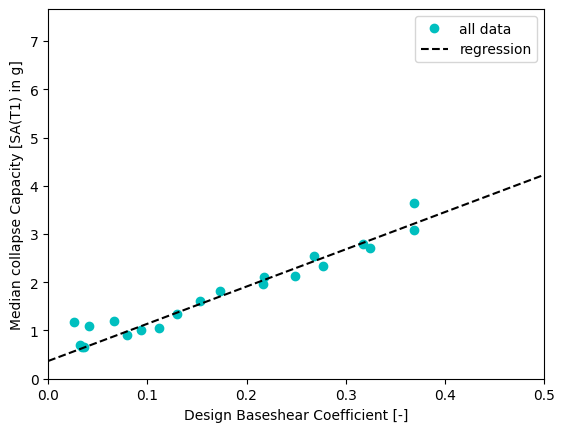

In [33]:
# regression of all of the data
x_min = 0.05   # N
df = building_data_df[building_data_df["vb_coeff"] > x_min]

result_all = linregress(df["vb_coeff"], df["theta_c_SaT1"])
print(f"Slope: {result_all.slope}")
print(f"Intercept: {result_all.intercept}")
print(f"R value: {result_all.rvalue}")

x_all = np.linspace(0, 0.9)
y_all = result_all.slope * x_all + result_all.intercept

plt.figure()
ax = plt.gca()
ax.plot(building_data_df["vb_coeff"], building_data_df["theta_c_SaT1"], color= "c", marker="o", ls="", label="all data")
ax.plot(x_all, y_all, color= "k", marker="", ls="--", label="regression")
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0, 0.5)
ax.set_ylim(0)
ax.legend()

(0.0, 8.710318018285207)

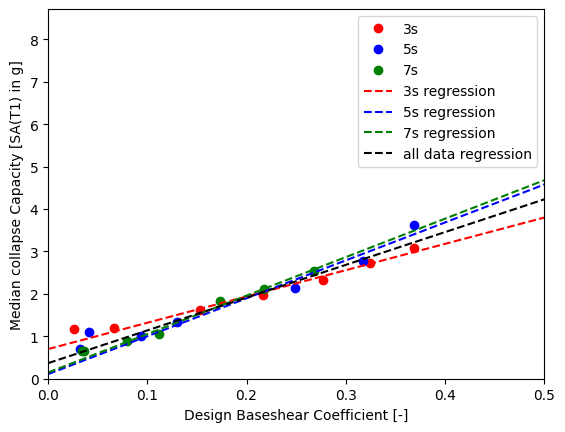

In [34]:
# plot all the data together
plt.figure()
ax = plt.gca()
ax.plot(df_3s["vb_coeff"], df_3s["theta_c_SaT1"], color= "r", marker="o", ls="", label="3s")
ax.plot(df_5s["vb_coeff"], df_5s["theta_c_SaT1"], color= "b", marker="o", ls="", label="5s")
ax.plot(df_7s["vb_coeff"], df_7s["theta_c_SaT1"], color= "g", marker="o", ls="", label="7s")
ax.plot(x_3s, y_3s, color= "r", marker="", ls="--", label="3s regression")
ax.plot(x_5s, y_5s, color= "b", marker="", ls="--", label="5s regression")
ax.plot(x_7s, y_7s, color= "g", marker="", ls="--", label="7s regression")
ax.plot(x_all, y_all, color= "k", marker="", ls="--", label="all data regression")
ax.legend()
ax.set_xlabel("Design Baseshear Coefficient [-]")
ax.set_ylabel("Median collapse Capacity [SA(T1) in g]")
ax.set_xlim(0, 0.5)
ax.set_ylim(0)


Regression analysis on all the data but his time the median collapse capacity is on the x axis

Slope: 0.13202944197995228
Intercept: -0.05891704874460019
R value: 0.9719437319783821


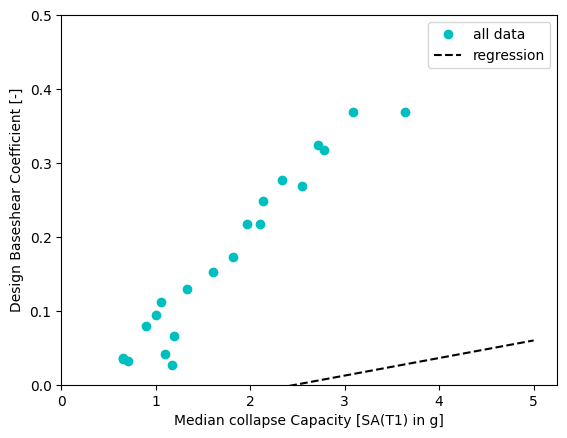

In [35]:
# regression of all of the data
y_min = 0.0   # N
df = building_data_df[building_data_df["vb_coeff"] > y_min]

result_all_0 = linregress(df["theta_c_SaT1"], df["vb_coeff"])
print(f"Slope: {result_all_0.slope}")
print(f"Intercept: {result_all_0.intercept}")
print(f"R value: {result_all_0.rvalue}")

x_all_0 = np.linspace(0, 5)
y_all_0 = result_all_0.slope * x_all + result_all_0.intercept

plt.figure()
ax = plt.gca()
ax.plot(building_data_df["theta_c_SaT1"], building_data_df["vb_coeff"], color= "c", marker="o", ls="", label="all data")
ax.plot(x_all_0, y_all_0, color= "k", marker="", ls="--", label="regression")
ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Median collapse Capacity [SA(T1) in g]")
ax.set_ylim(0, 0.5)
ax.set_xlim(0)
ax.legend()

Slope: 0.12354515761715984
Intercept: -0.03547079348709023
R value: 0.9765443858293853


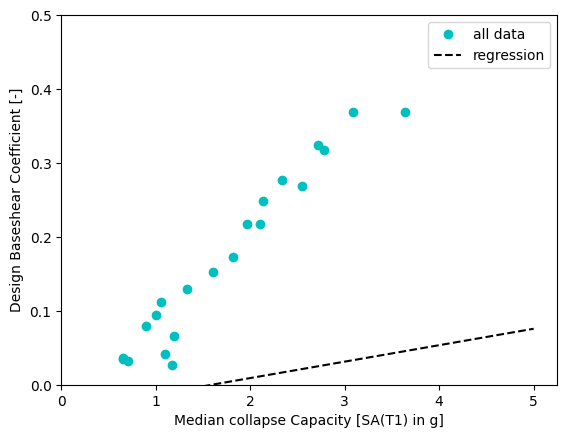

In [36]:
# regression of all of the data
y_min = 0.05  
df = building_data_df[building_data_df["vb_coeff"] > y_min]

result_all_005 = linregress(df["theta_c_SaT1"], df["vb_coeff"])
print(f"Slope: {result_all_005.slope}")
print(f"Intercept: {result_all_005.intercept}")
print(f"R value: {result_all_005.rvalue}")

x_all_005 = np.linspace(0, 5)
y_all_005 = result_all_005.slope * x_all + result_all_005.intercept

plt.figure()
ax = plt.gca()
ax.plot(building_data_df["theta_c_SaT1"], building_data_df["vb_coeff"], color= "c", marker="o", ls="", label="all data")
ax.plot(x_all_005, y_all_005, color= "k", marker="", ls="--", label="regression")
ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Median collapse Capacity [SA(T1) in g]")
ax.set_ylim(0, 0.5)
ax.set_xlim(0)
ax.legend()

Slope: 0.11909365627564218
Intercept: -0.023177802541317627
R value: 0.9818247489961881


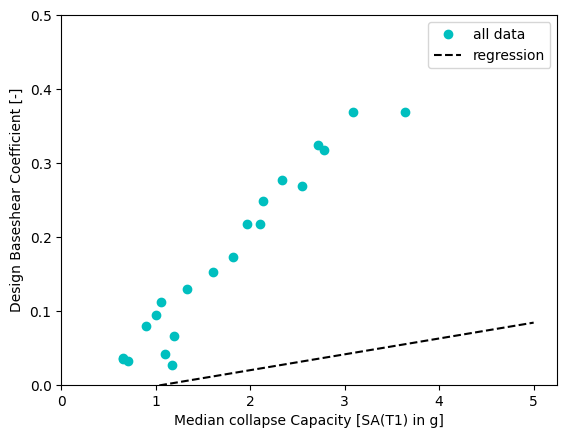

In [37]:
# regression of all of the data above design level 0.2:
df = building_data_df[building_data_df["design_level"] > 0.2]

result_all_gt02g = linregress(df["theta_c_SaT1"], df["vb_coeff"])
print(f"Slope: {result_all_gt02g.slope}")
print(f"Intercept: {result_all_gt02g.intercept}")
print(f"R value: {result_all_gt02g.rvalue}")

x_all_gt02g = np.linspace(0, 5)
y_all_gt02g = result_all_gt02g.slope * x_all + result_all_gt02g.intercept

plt.figure()
ax = plt.gca()
ax.plot(building_data_df["theta_c_SaT1"], building_data_df["vb_coeff"], color= "c", marker="o", ls="", label="all data")
ax.plot(x_all_gt02g, y_all_gt02g, color= "k", marker="", ls="--", label="regression")
ax.set_ylabel("Design Baseshear Coefficient [-]")
ax.set_xlabel("Median collapse Capacity [SA(T1) in g]")
ax.set_ylim(0, 0.5)
ax.set_xlim(0)
ax.legend()

In [38]:
# median collapse capacity of all structures with design level <= 0.2g
df = building_data_df[building_data_df["design_level"] <= 0.1]
plateau_mean = df['theta_c_SaT1'].mean()
print(f"mean value: {plateau_mean} [g]")

# intersection with regression line
vb_intersect = result_all_gt02g.slope * plateau_mean + result_all_gt02g.intercept
print(f"intersection with regression: vb_coeff = {vb_intersect}")

# regression line for plotting:
x_regress = np.linspace(plateau_mean, 4)
y_regress = result_all_gt02g.slope * x_regress + result_all_gt02g.intercept

mean value: 0.8460906480931348 [g]
intersection with regression: vb_coeff = 0.0775862262807215


Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0


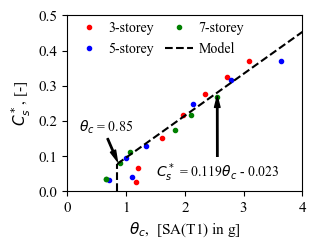

In [39]:
# plot all the data together
cm = 1 / 2.54
plt.figure(figsize=(7.7*cm, 5.8*cm))
ax = plt.gca()
ax.plot(df_3s["theta_c_SaT1"], df_3s["vb_coeff"], color= "r", marker=".", ls="", label="3-storey")
ax.plot(df_5s["theta_c_SaT1"], df_5s["vb_coeff"], color= "b", marker=".", ls="", label="5-storey")
ax.plot(df_7s["theta_c_SaT1"], df_7s["vb_coeff"], color= "g", marker=".", ls="", label="7-storey")
# ax.plot(x_all_0, y_all_0, color= "r", marker="", ls="--", label="Regression with Plateau = 0.0")
# ax.plot(x_all_005, y_all_005, color= "g", marker="", ls="--", label="Regression = 0.05")
ax.plot(x_regress, y_regress, color= "k", marker="", ls="--", label="Model")
ax.plot([plateau_mean, plateau_mean], [0, vb_intersect], color= "k", marker="", ls="--",)

axis_font = font_manager.FontProperties(family='Times New Roman',
                                          style='normal', size=11)
axis_font_dict=axis_font.get_fontconfig_pattern()
print(axis_font_dict)

ax.set_ylabel("$C_{s}^*$, [-]", fontproperties=axis_font)
ax.set_xlabel(r"$\theta_{c}$,  [SA(T1) in g]", fontproperties=axis_font)
ax.set_xlim(0, 4)
ax.set_ylim(0, 0.5)

x_labels = ax.get_xticklabels()
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks, x_labels, font="Times New Roman", size=11)

y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks, y_labels, font="Times New Roman", size=11)

legend_font = font_manager.FontProperties(family='Times New Roman',
                                          style='normal', size=10)

ax.legend(frameon=False, ncol=2, handletextpad=0.4, columnspacing=0.8, prop=legend_font,
         loc="upper left", bbox_to_anchor=(-0.02, 0.54, 0.2, 0.5))

ax.annotate(r"$C_{s}^*$ = 0.119$\theta_{c}$ - 0.023", xy=(2.55, 0.27), xytext=(1.5, 0.04), textcoords="data", 
            arrowprops=dict(width=1, headwidth=4, headlength=8, facecolor='black', shrink=0.0),
            bbox=dict(boxstyle="square", fc="white", ec="none", lw=0), fontproperties=legend_font)
ax.annotate(r"$\theta_{c}$ = 0.85", xy=(0.85, 0.085), xytext=(0.2, 0.17), textcoords="data",
            arrowprops=dict(width=1, headwidth=4, headlength=8, facecolor='black', shrink=0.0), fontproperties=legend_font)

save_file = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/03_papers/04_DACH_Tagung_2025_cbf_fragility_curves") / "results.png"
plt.savefig(save_file, dpi=1000, edgecolor="none", bbox_inches="tight")

(0.0, 0.5)

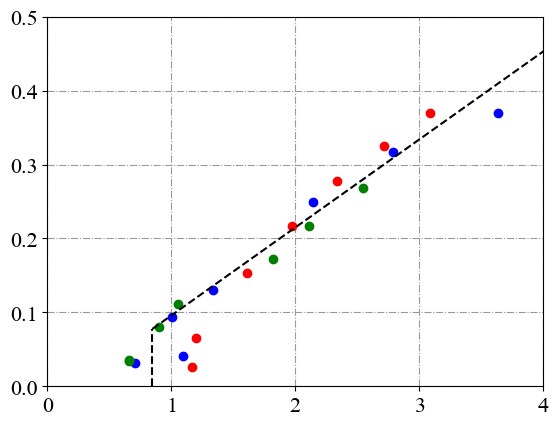

In [57]:
# plot all the data together
plt.figure()
ax = plt.gca()
ax.plot(df_3s["theta_c_SaT1"], df_3s["vb_coeff"], color= "r", marker="o", ls="", label="3-storey")
ax.plot(df_5s["theta_c_SaT1"], df_5s["vb_coeff"], color= "b", marker="o", ls="", label="5-storey")
ax.plot(df_7s["theta_c_SaT1"], df_7s["vb_coeff"], color= "g", marker="o", ls="", label="7-storey")
ax.plot(x_regress, y_regress, color= "k", marker="", ls="--")
ax.plot([plateau_mean, plateau_mean], [0, vb_intersect], color= "k", marker="", ls="--",)

y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks, y_labels, font="Times New Roman", size=16)
ax.set_xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], font="Times New Roman", size=16)
ax.grid(True, which="major", color="0.6", linestyle="-.")

ax.set_xlim(0, 4)
ax.set_ylim(0, 0.5)

# save_file = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/03_papers/04_DACH_Tagung_2025_cbf_fragility_curves") / "results.png"
# plt.savefig(save_file, dpi=1000, edgecolor="none", bbox_inches="tight")

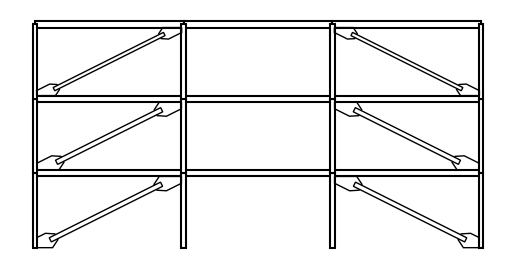

In [40]:
# plot the system
model_file_path = Path("E:/case_study_structures/DC2/design_output_json_files/3s_cbf_dc2_41_out.json")
fig, ax = plot_model_2d(model_file_path, beam_labels=False, column_labels=False, brace_labels=False, show_axes=False, show_fig=False)
save_file = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/03_papers/04_DACH_Tagung_2025_cbf_fragility_curves") / "3s_frame.png"
plt.savefig(save_file, dpi=300, bbox_inches="tight")

In [41]:
df_3s

,name,n_storeys,design_level,ductility_class,T1,T2,T3,mass_ratio_1,mass_ratio_2,mass_ratio_3,...,F_beta,F_T,F_A,site_category,S_delta,delta,n_bays,height,width,vb_coeff
1,3s_cbf_dc2_10,3,0.10,2,0.649888,0.240027,0.151604,88.823450,9.330153,1.833209e+00,...,2.28620,1.0,2.5,low,0.156800,1.0,3.0,10500.0,21000.0,0.026098
4,3s_cbf_dc2_20,3,0.20,2,0.541700,0.194938,0.123839,88.825179,9.411824,1.739859e+00,...,2.27240,1.0,2.5,low,0.307200,1.0,3.0,10500.0,21000.0,0.065958
5,3s_cbf_dc2_31,3,0.31,2,0.447962,0.165406,0.102322,84.872104,11.778375,3.291886e+00,...,2.23583,1.0,2.5,moderate,0.465248,1.0,3.0,10500.0,21000.0,0.152712
6,3s_cbf_dc2_41,3,0.41,2,0.408288,0.146735,0.092269,84.487736,11.849241,3.582587e+00,...,2.21513,1.0,2.5,moderate,0.602208,1.0,3.0,10500.0,21000.0,0.217078
7,3s_cbf_dc2_51,3,0.51,2,0.366747,0.134082,0.087660,83.655715,12.275207,1.267465e-06,...,2.15924,1.0,2.5,high,0.732768,1.0,3.0,10500.0,21000.0,0.277564
8,3s_cbf_dc2_61,3,0.61,2,0.350979,0.125884,0.081603,83.474234,12.322531,5.345955e-07,...,2.13164,1.0,2.5,high,0.856928,1.0,3.0,10500.0,21000.0,0.324594
9,3s_cbf_dc2_71,3,0.71,2,0.333037,0.121442,0.081240,83.105765,12.560690,9.672799e-07,...,2.10404,1.0,2.5,high,0.974688,1.0,3.0,10500.0,21000.0,0.369200


In [42]:
df_3s.loc[:,["name", "design_level", "T1", "theta_c_SaT1", "lambda_", "vb_coeff", "site_category", "q_design", "vertical_regularity"]]

,name,design_level,T1,theta_c_SaT1,lambda_,vb_coeff,site_category,q_design,vertical_regularity
1,3s_cbf_dc2_10,0.10,0.649888,1.168645,1.00,0.026098,low,2.433454,False
4,3s_cbf_dc2_20,0.20,0.541700,1.194976,1.00,0.065958,low,2.244000,False
5,3s_cbf_dc2_31,0.31,0.447962,1.608599,0.85,0.152712,moderate,2.244000,False
6,3s_cbf_dc2_41,0.41,0.408288,1.969256,0.85,0.217078,moderate,2.244000,False
7,3s_cbf_dc2_51,0.51,0.366747,2.338196,0.85,0.277564,high,2.244000,False
8,3s_cbf_dc2_61,0.61,0.350979,2.717660,0.85,0.324594,high,2.244000,False
9,3s_cbf_dc2_71,0.71,0.333037,3.084657,0.85,0.369200,high,2.244000,False


In [43]:
df_5s.loc[:,["name", "design_level", "T1", "design_period", "theta_c_SaT1", "lambda_", "vb_coeff", "site_category", "q_design", "vertical_regularity"]]

,name,design_level,T1,design_period,theta_c_SaT1,lambda_,vb_coeff,site_category,q_design,vertical_regularity
11,5s_cbf_dc2_10,0.10,0.911185,1.032673,0.708546,1.00,0.031682,low,1.397552,False
14,5s_cbf_dc2_20,0.20,0.852029,0.975218,1.094520,1.00,0.041536,low,2.244000,False
15,5s_cbf_dc2_31,0.31,0.727523,0.839185,1.002051,0.85,0.093856,moderate,2.244000,False
16,5s_cbf_dc2_41,0.41,0.687969,0.795819,1.335859,0.85,0.129684,moderate,2.244000,False
17,5s_cbf_dc2_51,0.51,0.556085,0.669956,2.139104,0.85,0.249047,high,2.244000,False
18,5s_cbf_dc2_61,0.61,0.507238,0.621362,2.786082,0.85,0.317070,high,2.244000,False
19,5s_cbf_dc2_71,0.71,0.466816,0.583738,3.633295,0.85,0.369200,high,2.244000,False


In [44]:
df_7s.loc[:,["name", "design_level", "T1", "design_period", "theta_c_SaT1", "lambda_", "vb_coeff", "site_category", "q_design", "vertical_regularity"]]

,name,design_level,T1,design_period,theta_c_SaT1,lambda_,vb_coeff,site_category,q_design,vertical_regularity
21,7s_cbf_dc2_10,0.10,1.176016,1.338191,0.656185,1.00,0.034169,low,1.000000,False
22,7s_cbf_dc2_20,0.20,1.176016,1.338191,0.656185,1.00,0.035936,low,1.890175,False
23,7s_cbf_dc2_31,0.31,1.008622,1.163449,0.896834,1.00,0.079644,moderate,2.244000,False
24,7s_cbf_dc2_41,0.41,0.932006,1.090463,1.056483,1.00,0.111345,moderate,2.244000,False
25,7s_cbf_dc2_51,0.51,0.813226,0.965863,1.822122,0.85,0.172747,high,2.244000,False
26,7s_cbf_dc2_61,0.61,0.741957,0.906495,2.107147,0.85,0.217337,high,2.244000,False
27,7s_cbf_dc2_71,0.71,0.673777,0.843522,2.546087,0.85,0.268332,high,2.244000,False
